# Notebook to quickly look at EMG abf outputs

Want to see if I can pull out spikes and WBF data, align them

## Imports

In [1]:
import os
import glob
import pyabf

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy import signal

# from mosquito.read_photron import my_read_cih

## Helper functions

In [2]:
def idx_by_thresh(signal, thresh=0.1):
    """
    Returns a list of index lists, where each index indicates where signal > thresh

    If I'm remembering correctly, there's some ambiguity in the edge cases
    """
    # import numpy as np
    idxs = np.squeeze(np.argwhere((signal > thresh).astype(int)))
    try:
        split_idxs = np.squeeze(np.argwhere(np.diff(idxs) > 1))
    except IndexError:
        # print 'IndexError'
        return None
    # split_idxs = [split_idxs]
    if split_idxs.ndim == 0:
        split_idxs = np.array([split_idxs])
    # print split_idxs
    try:
        idx_list = np.split(idxs, split_idxs)
    except ValueError:
        # print 'value error'
        np.split(idxs, split_idxs)
        return None
    idx_list = [x[1:] for x in idx_list]
    idx_list = [x for x in idx_list if len(x) > 0]
    return idx_list


In [3]:
def butter_bandpass(lowcut, highcut, sampling_period, order=5, btype='band'):
    import scipy.signal
    sampling_frequency = 1.0 / sampling_period
    nyq = 0.5 * sampling_frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = scipy.signal.butter(order, [low, high], btype=btype, output='sos')
    return sos



In [4]:
def butter_bandpass_filter(data, lowcut, highcut, sampling_period, order=5, btype='band'):
    import scipy.signal
    sos = butter_bandpass(lowcut, highcut, sampling_period, order=order, btype=btype)
    y = scipy.signal.sosfiltfilt(sos, data)
    return y


In [5]:
def iir_notch(cut_freq, sampling_period, Q=30):
    import scipy.signal
    sampling_frequency = 1.0 / sampling_period
    b, a = scipy.signal.iirnotch(cut_freq, Q, fs=sampling_frequency)
    return b, a


In [6]:
def iir_notch_filter(data, cut_freq, sampling_period, Q=30):
    import scipy.signal
    b, a = iir_notch(cut_freq, sampling_period, Q=Q)
    y = scipy.signal.filtfilt(b, a, data)
    return y


## Set params

In [7]:
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

## Load data

In [40]:
# paths to data
data_root = '/media/sam/SamData/Mosquitoes'
data_folder = '04_20240321' # '05_20240322'  #'08_20240401' # '04_20240321' #   '05_20240322'  # '03_20240319' # 
axo_num = 2
vid_str = 'aedes_C001H001S0001_20240326_154951'

data_path = os.path.join(data_root, data_folder, '*_{:04d}'.format(axo_num))
abf_dir = glob.glob(os.path.join(data_path, '*.abf'))

abf_path = abf_dir[0]

print(abf_path)

/media/sam/SamData/Mosquitoes/04_20240321/2024_03_21_0002/2024_03_21_0002.abf


In [41]:
os.path.split(abf_path)

('/media/sam/SamData/Mosquitoes/04_20240321/2024_03_21_0002',
 '2024_03_21_0002.abf')

In [42]:
# load abf file
abf = pyabf.ABF(abf_path)
abf

ABF (v2.9) with 3 channels (V, V, V), sampled at 35.087 kHz, containing 1 sweep, having no tags, with a total length of 8.55 minutes, recorded with protocol "mosquito_emg_protocol_gapfree_v0". path=/media/sam/SamData/Mosquitoes/04_20240321/2024_03_21_0002/2024_03_21_0002.abf

In [43]:
print(abf.headerText)


ABF Class Methods
abf.getAllXs()
abf.getAllYs()
abf.launchInClampFit()
abf.saveABF1()
abf.setSweep()
abf.sweepD()

ABF Class Variables
abfDateTime = 2024-03-21 12:39:06.317000
abfDateTimeString = 2024-03-21T12:39:06.317
abfFileComment =
abfFilePath = /media/sam/SamData/Mosquitoes/04_20240321/2024_03_21_0002/2024_03_21_0002.abf
abfFolderPath = /media/sam/SamData/Mosquitoes/04_20240321/2024_03_21_0002
abfID = 2024_03_21_0002
abfVersion = {'major': 2, 'minor': 9, 'bugfix': 0, 'build': 0}
abfVersionString = 2.9.0.0
adcNames = ['EMG', 'CAM', 'Microphon']
adcUnits = ['V', 'V', 'V']
channelCount = 3
channelList = [0, 1, 2]
creator = AxoScope 11.3.0.2
creatorVersion = {'major': 11, 'minor': 3, 'bugfix': 0, 'build': 2}
creatorVersionString = 11.3.0.2
dacNames = ['Cmd 0', 'Cmd 1', 'Cmd 2']
dacUnits = ['mV', 'mV', 'mV']
data = [[-0.0031 -0.0031 -0.0024 ...  0.0067  0.0067  0.0067]
[ 0.      0.0003  0.     ...  0.0003  0.      0.0003]
[-2.3816 -2.807  -3.0734 ... -0.3802 -0.22   -0.1315]]
dataByt

In [44]:
# grab data from abf
Fs = abf.sampleRate  # sampling frequency
channel_names = abf.adcNames

# channel data
abf_dict = dict()

for ith, name in enumerate(channel_names):
    # set channel
    abf.setSweep(sweepNumber=0, channel=ith)
    
    # get time once
    if ith == 0:
        abf_dict['Time'] = abf.sweepX
        
    # get current channel data
    abf_dict[name] = abf.sweepY


In [45]:
# convert dict to dataframe
abf_df = pd.DataFrame.from_dict(abf_dict)

abf_df

,Time,EMG,CAM,Microphon
0,0.000000,-0.003052,0.000000,-2.381592
1,0.000029,-0.003052,0.000305,-2.807007
2,0.000057,-0.002441,0.000000,-3.073425
3,0.000086,-0.002136,0.000305,-3.113098
4,0.000114,-0.002136,0.000305,-2.943726
...,...,...,...,...
17995259,512.875395,0.006714,0.000305,-0.439453
17995260,512.875424,0.005798,0.000305,-0.474243
17995261,512.875452,0.006714,0.000305,-0.380249
17995262,512.875481,0.006714,0.000000,-0.220032


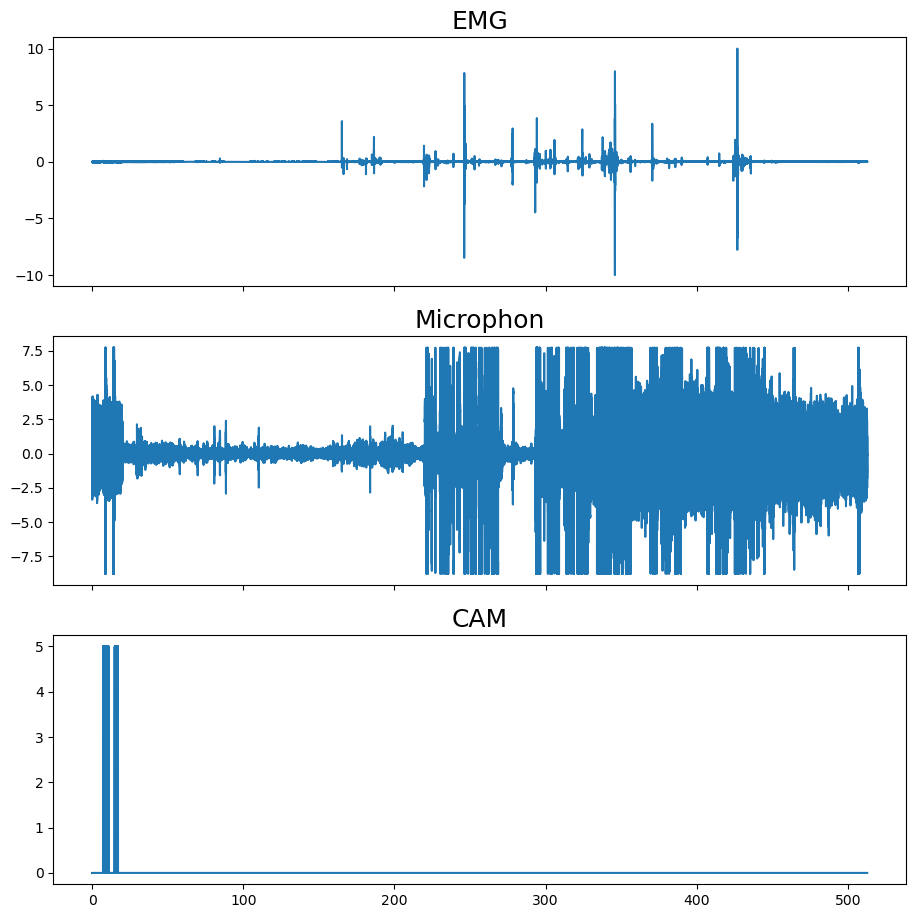

In [46]:
# test that we got data alright
var_names = ['EMG', 'Microphon', 'CAM']
fig, ax_list = plt.subplots(len(var_names),1,figsize=(11,11),sharex=True)
ax_list = ax_list.ravel()


for jth, vname in enumerate(var_names):
    ax_list[jth].plot(abf_df['Time'], abf_df[vname])
    ax_list[jth].autoscale(enable=True, axis='xy', tight=True)
    ax_list[jth].set_title(vname)
    
# ax_list[0].set_xlim([0.0, 1.5])
# ax_list[0].set_ylim([-0.1, 0.1])

## Look at camera signal

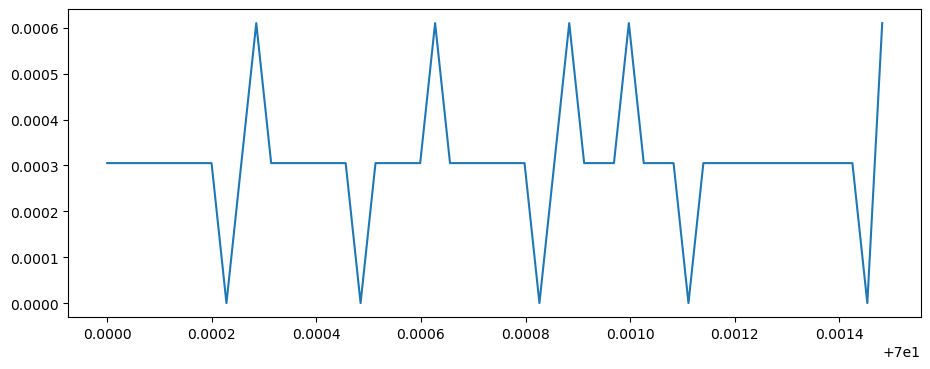

In [47]:
# find a region in which the camera is recording
fig, ax = plt.subplots(figsize=(11,4))

xmin = 70
xmax = 70.0015
mask = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)

ax.plot(abf_df['Time'][mask], abf_df['CAM'][mask])
# ax.set_xlim([3.35, 3.352])

In [48]:
# look at periods of HIGH
cam_idx_list = idx_by_thresh(abf_df['CAM'])
# abf_df['CAM'][116896]

# assign an indexto each open shutter point
# note that this will give non-integer values
cam_idx = []
for idx_list in cam_idx_list:
    cam_idx.append(np.mean(np.hstack((idx_list, idx_list[-1]+1))))
    
# cam_idx

In [49]:
len(cam_idx)

43830

In [50]:
# find ones that should corresponds to actual recording
# (currently we get sync during 'READY' and 'RECORD' states)
try:
    cihx_path = os.path.join(data_path, vid_str, '{}.cihx'.format(vid_str))
    cihx_info = my_read_cih(cihx_path)
    n_frames = cihx_info['Total Frame']

except:
    print('Could not load cihx file for this movie--probably wrong filename')
    n_frames = 13973
"""
This still needs to be completed!
"""

Could not load cihx file for this movie--probably wrong filename


'\nThis still needs to be completed!\n'

## Process microphone data

In [51]:
# try to bandpass filter the data so we just get out wingbeat signal
lowcut = 200  # 200
highcut = 850

microphone_filt = butter_bandpass_filter(abf_df['Microphon'], lowcut, highcut, 1/Fs)
# microphone_filt = iir_notch_filter(abf_df['Microphon'], 411, 1/Fs)
abf_df['Microphon_filt'] = microphone_filt

Text(0.5, 0, 'time (s)')

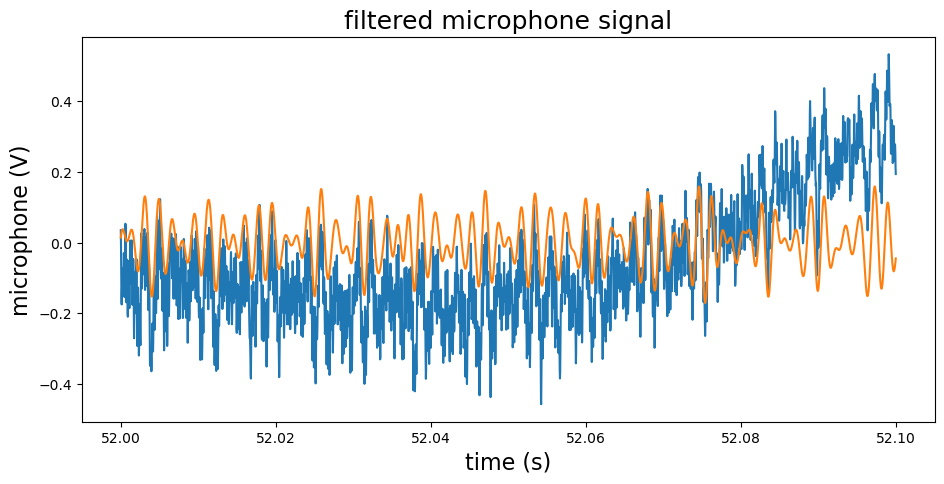

In [52]:
# look at filtered signal
fig, ax = plt.subplots(figsize=(11,5))

xmin = 52 
xmax = 52.1
mask = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)

ax.plot(abf_df['Time'][mask], abf_df['Microphon'][mask])
ax.plot(abf_df['Time'][mask], abf_df['Microphon_filt'][mask])

# ax.set_xlim([0,0.05])
ax.set_title('filtered microphone signal')
ax.set_ylabel('microphone (V)')
ax.set_xlabel('time (s)')

In [53]:
np.round(Fs/900)

39.0

Text(0.5, 0, 'time (s)')

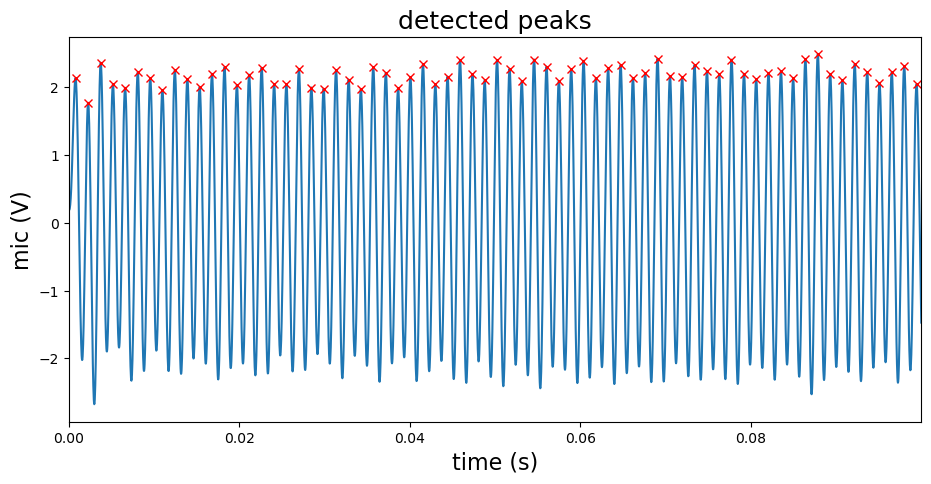

In [54]:
# which gives best wbf measurement? PSD or direct difference calc
mic_peak_dist = np.round(Fs/900)
mic_peaks, _ = signal.find_peaks(abf_df['Microphon_filt'], 
                                 distance=mic_peak_dist)

fig, ax = plt.subplots(figsize=(11,5))

xmin = 0
xmax = 0.1
mask = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)
peaks_mask = (abf_df['Time'][mic_peaks] >= xmin) & (abf_df['Time'][mic_peaks] <= xmax)

ax.plot(abf_df['Time'][mask], abf_df['Microphon_filt'][mask])
ax.plot(abf_df['Time'][mic_peaks][peaks_mask], abf_df['Microphon_filt'][mic_peaks][peaks_mask], 'rx')

# ax.set_xlim([10, 11])
# ax.set_ylim([-0.05, 0.05])
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_title('detected peaks')
ax.set_ylabel('mic (V)')
ax.set_xlabel('time (s)')


In [55]:
# get mean difference
dt = np.diff(mic_peaks)
dt_mean = (1/Fs)*np.mean(dt)
print(1/dt_mean)

543.303698855494


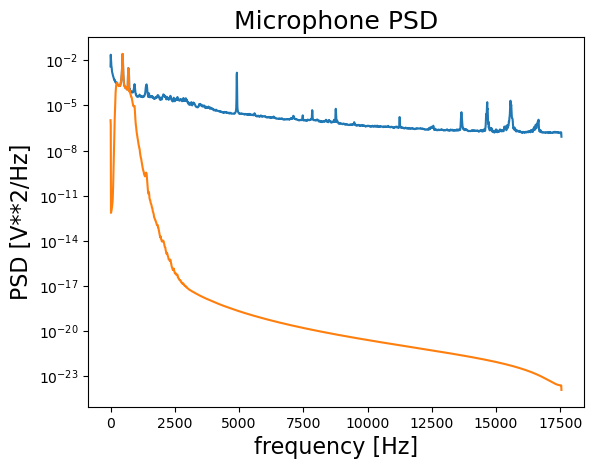

In [56]:
# power spectral density of filtered data
nperseg = 4096
f, Pxx_den = signal.welch(abf_df['Microphon'], Fs, nperseg=nperseg)
f, Pxx_den_filt = signal.welch(abf_df['Microphon_filt'], Fs, nperseg=nperseg)
plt.semilogy(f, Pxx_den)
plt.semilogy(f, Pxx_den_filt)
# plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Microphone PSD')
plt.show()

In [57]:
# find peak of PSD
max_ind = np.argmax(Pxx_den)
wbf_mean = f[max_ind]
wbf_mean

471.138916015625

## Process EMG data 

NB: am finding that I can't totally remove wbf noise. maybe a wavelet approach would work better?

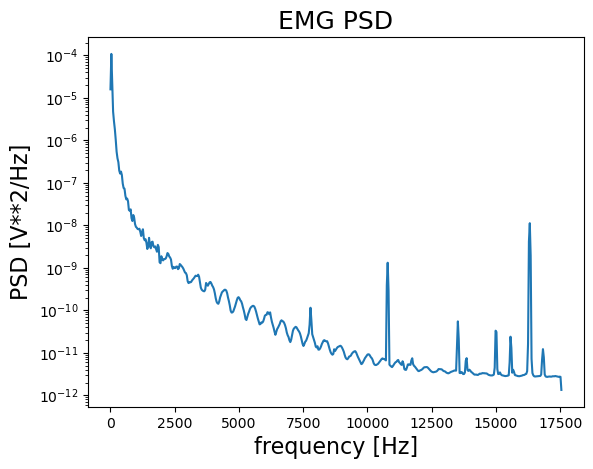

In [58]:
# first look at PSD
nperseg = 1028
f, Pxx_den = signal.welch(abf_df['EMG'], Fs, nperseg=nperseg)
plt.semilogy(f, Pxx_den)
# plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('EMG PSD')
plt.show()

In [59]:
max_ind = np.argmax(Pxx_den)
f[max_ind]

34.13132295719845

In [60]:
# # filtering for STEERING muscles
# try notch filter to remove wbf signal 
cut_freq = wbf_mean

emg_filt = iir_notch_filter(abf_df['EMG'], cut_freq, 1/Fs, Q=2.0)  # Q=0.5

# also use bandpass filter to remove noise at extremes
lowcut =  500 # 2.0 # 500 # 
highcut = 10000 # 50 # 10000 # 

emg_filt = butter_bandpass_filter(emg_filt, lowcut, highcut, 1/Fs)

abf_df['EMG_filt'] = emg_filt


In [61]:
# filtering for POWER muscles

# # try notch filter to remove wbf signal 
# cut_freq = wbf_mean

# emg_filt = iir_notch_filter(abf_df['EMG'], cut_freq, 1/Fs, Q=2.0)  # Q=0.5

# # also use bandpass filter to remove noise at extremes
# # lowcut = 55 # 200
# # highcut = 2000 # 2000 # 10000

# lowcut = 1 # 200
# highcut = 50 # 2000 # 10000

# emg_filt = butter_bandpass_filter(emg_filt, lowcut, highcut, 1/Fs, btype='bandpass')
# abf_df['EMG_filt'] = emg_filt


Text(0.5, 0, 'time (s)')

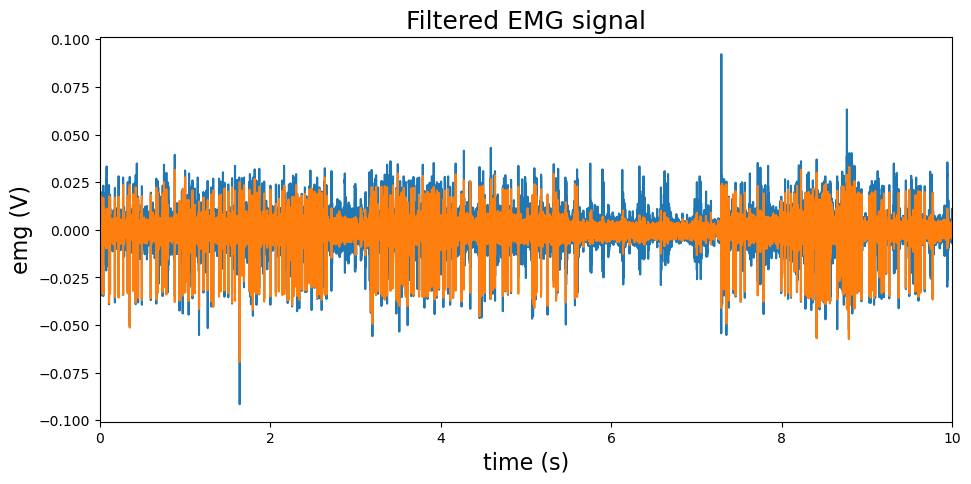

In [62]:
# look at filtered signal
fig, ax = plt.subplots(figsize=(11,5))

xmin = 0
xmax = 10
mask = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)

ax.plot(abf_df['Time'][mask], abf_df['EMG'][mask])
ax.plot(abf_df['Time'][mask], abf_df['EMG_filt'][mask])

# ax.set_xlim([0.1, 0.2])
# ax.set_ylim([-0.05, 0.05])
# ax.set_xlim([10.00, 10.015])
# autoscale_y(ax)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_title('Filtered EMG signal')
ax.set_ylabel('emg (V)')
ax.set_xlabel('time (s)')


## Spike detection

Need to align and detect spikes

In [63]:
# set threshold for detection
mad = np.median(np.abs(abf_df['EMG_filt']))
thresh = 5*mad/0.6745  # 0.6745 is the factor relating median absolute deviation to standard deviation (sometimes)
thresh

0.004419153232789476

Text(0.5, 0, 'time (s)')

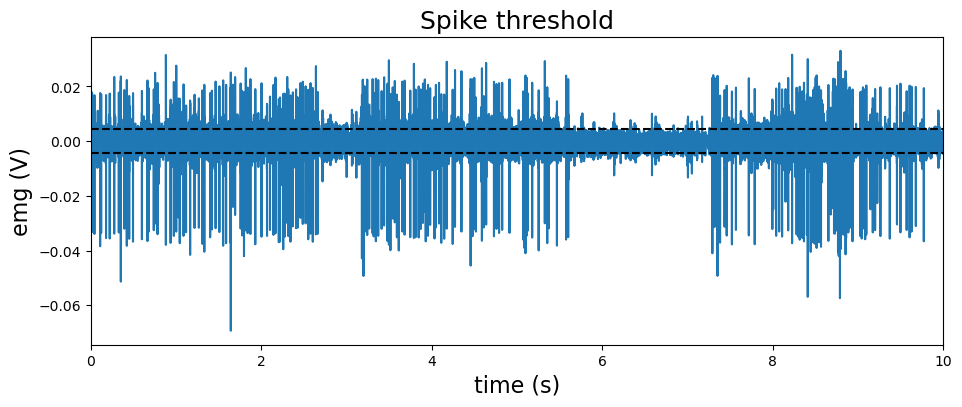

In [64]:
# visualize thresh
fig, ax = plt.subplots(figsize=(11,4))


xmin =  0.0 #0.69 # 10.17
xmax =  10  # 0.3  # 0.71 #10.25
mask = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)

ax.plot(abf_df['Time'][mask], abf_df['EMG_filt'][mask])
ax.axhline(thresh, color='k', ls='--')
ax.axhline(-1*thresh, color='k', ls='--')

# ax.set_xlim([10.00, 10.2])
# ax.set_ylim([-0.03, 0.03])
# autoscale_y(ax)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_title('Spike threshold')
ax.set_ylabel('emg (V)')
ax.set_xlabel('time (s)')

In [90]:
# to get spikes, going to find peaks above threshold, take window around these, and center
# to avoid double counting, set minimum distance between peaks
# NB: TEMPORARILY BOOSTING THRESH
min_peak_dist = 52 # 10
min_height = 2*thresh  # 2*
max_height = 8*thresh # 8*
peaks, props = signal.find_peaks(np.abs(abf_df['EMG_filt']), 
                                 height=(min_height, max_height), 
                                 distance=min_peak_dist, 
                                 prominence=(None, None), 
                                 threshold=(None, None)) 

In [91]:
# props
print(props['left_bases'][:12])
print(props['right_bases'][:12])

[  73  307  960 ... 7745 7841 8308]
[  307   960  3257 ...  8308  8308 12307]


Text(0.5, 0, 'time (s)')

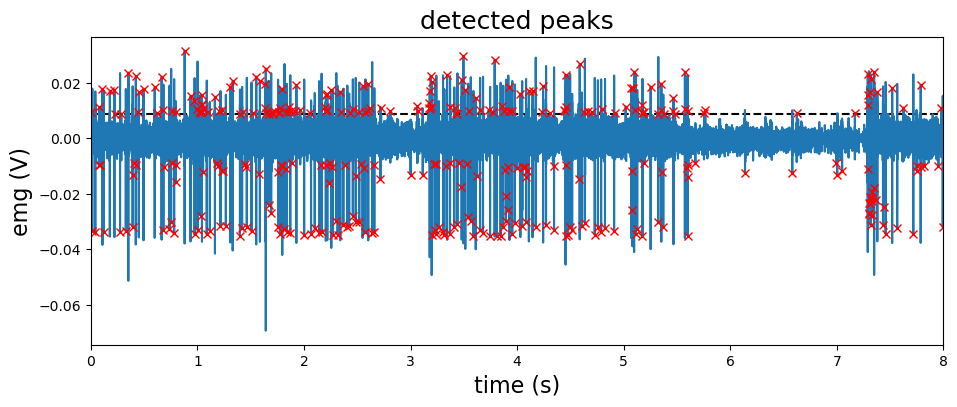

In [92]:
# visualize peaks
fig, ax = plt.subplots(figsize=(11,4))

xmin =  0 # 0.69 # 10.17
xmax =  8 # 0.3 # 0.71 #10.25
mask = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)
peaks_mask = (abf_df['Time'][peaks] >= xmin) & (abf_df['Time'][peaks] <= xmax)

ax.axhline(min_height, color='k', ls='--')
ax.plot(abf_df['Time'][mask], abf_df['EMG_filt'][mask])
ax.plot(abf_df['Time'][peaks][peaks_mask], abf_df['EMG_filt'][peaks][peaks_mask], 'rx')

# ax.set_xlim([0, 8])
# ax.set_ylim([-0.05, 0.05])
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_title('detected peaks')
ax.set_ylabel('emg (V)')
ax.set_xlabel('time (s)')

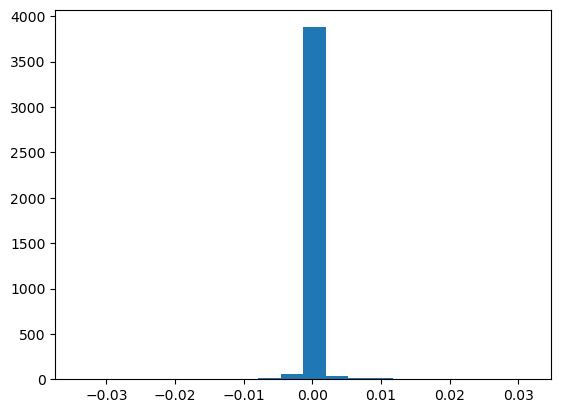

In [83]:
# can peak to trough difference help ID spikes?
left_diff = emg_filt[peaks] - emg_filt[props['left_bases']]
right_diff = emg_filt[peaks] - emg_filt[props['right_bases']]

fig, ax = plt.subplots()

# ax.hist(left_diff, bins=20) ;
# ax.hist(right_diff, bins=20) ;
ax.hist(emg_filt[props['right_bases']], bins=20) ;


In [72]:
# # how does it look when we remove low right_diff peaks?
# rm_idx = emg_filt[props['right_bases']] > -1*thresh
# # peaks = peaks[~rm_idx]
# peaks_trim = peaks[~rm_idx]
                  
# # visualize peaks
# fig, ax = plt.subplots(figsize=(11,4))

# xmin =  0 # 0.69 # 10.17
# xmax =  8 # 0.3 # 0.71 #10.25
# mask = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)
# peaks_mask = (abf_df['Time'][peaks_trim] >= xmin) & (abf_df['Time'][peaks_trim] <= xmax)

# ax.axhline(min_height, color='k', ls='--')
# ax.plot(abf_df['Time'][mask], abf_df['EMG_filt'][mask])
# ax.plot(abf_df['Time'][peaks_trim][peaks_mask], abf_df['EMG_filt'][peaks_trim][peaks_mask], 'rx')

# # ax.set_xlim([0, 8])
# # ax.set_ylim([-0.05, 0.05])
# ax.autoscale(enable=True, axis='x', tight=True)
# ax.set_title('detected peaks')
# ax.set_ylabel('emg (V)')
# ax.set_xlabel('time (s)')

In [73]:
# # extract window around detected peaks (+/- spike window)
# spike_window = 32  # power of 2 for wavelets

# spike_list = []
# spike_ind_list = []

# # loop over detected peaks
# for pk in peaks:
#     spike_ind = range(pk-spike_window, pk+spike_window)
    
#     # get window/peak location 
#     spike_ind_list.append(spike_ind)
#     spike_list.append(abf_df['EMG_filt'][spike_ind])

In [84]:
# extract window around detected peaks (+/- spike window)
spike_window = 32  # 4*4*128  #  4*4*128 # 32  # power of 2 for wavelets
offset = 4 # 256

N_pts = abf_df['EMG_filt'].size
spike_list = []
peaks_new = []
right_diff_new = []

# loop over detected peaks
for ith, pk in enumerate(peaks):
    # get range around current peak
    if (pk - spike_window) < 0 or (pk + spike_window) > N_pts:
        continue
        
    spike_ind_init = np.arange(pk-int(spike_window/2), pk+int(spike_window/2))
    
    # recenter to max value
    pk_new = spike_ind_init[np.argmax(abf_df['EMG_filt'][spike_ind_init])]
    spike_ind = np.arange(pk_new-spike_window+offset, pk_new+spike_window+offset)
    
    if (pk_new - spike_window) < 0 or (pk_new + spike_window) > N_pts:
        continue
        
    spike_waveform = abf_df['EMG_filt'][spike_ind]
    
    # get new window/peak location (but first check if we already have this spike)
    if not pk_new in peaks_new:
        peaks_new.append(pk_new)
        right_diff_new.append(right_diff[ith])
        spike_list.append(spike_waveform)

peaks = np.array(peaks_new)
right_diff_new = np.array(right_diff_new)


Text(0.5, 0, 'time (s)')

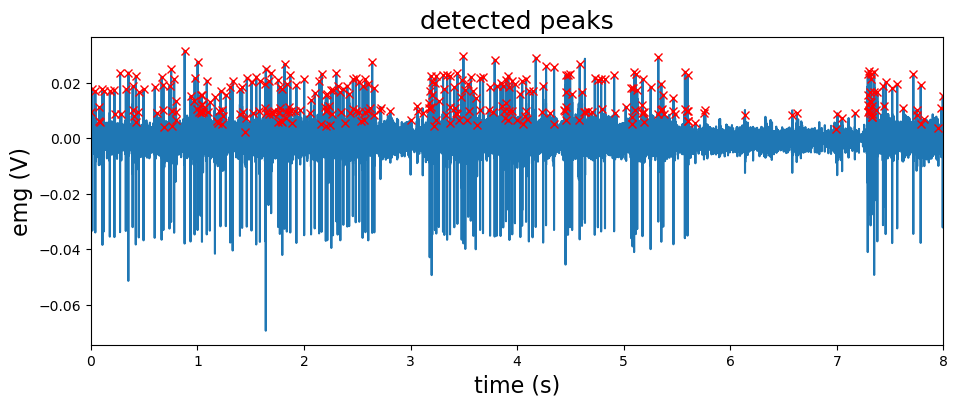

In [85]:
# visualize peaks
fig, ax = plt.subplots(figsize=(11,4))

xmin =  0 # 0.69 # 10.17
xmax =  8 # 0.3 # 0.71 #10.25
mask = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)
peaks_mask = (abf_df['Time'][peaks] >= xmin) & (abf_df['Time'][peaks] <= xmax)

ax.plot(abf_df['Time'][mask], abf_df['EMG_filt'][mask])
ax.plot(abf_df['Time'][peaks][peaks_mask], abf_df['EMG_filt'][peaks][peaks_mask], 'rx')

# ax.set_xlim([10, 11])
# ax.set_ylim([-0.05, 0.05])
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_title('detected peaks')
ax.set_ylabel('emg (V)')
ax.set_xlabel('time (s)')


In [93]:
# put in array form
spike_arr = np.vstack(spike_list)
spike_arr.shape


(4043, 64)

In [94]:
# timing for extracted spikes
spike_t = np.linspace(-1*spike_window/Fs, spike_window/Fs, spike_arr.shape[1])


In [95]:
# remove any obviously bad waveforms
spike_max = np.max(np.abs(spike_arr), axis=1)
spike_max_median = np.median(spike_max)
spike_max_mad = 1.4836*np.median(np.abs(spike_max - spike_max_median))

pseudo_z = (spike_max - spike_max_median)/spike_max_mad
rm_idx = np.abs(pseudo_z) > 25
np.sum(rm_idx)

spike_arr = spike_arr[~rm_idx,:]

# also need to remove peaks
peaks = peaks[~rm_idx]
np.sum(rm_idx)

6

Text(0.5, 1.0, 'all extracted spikes')

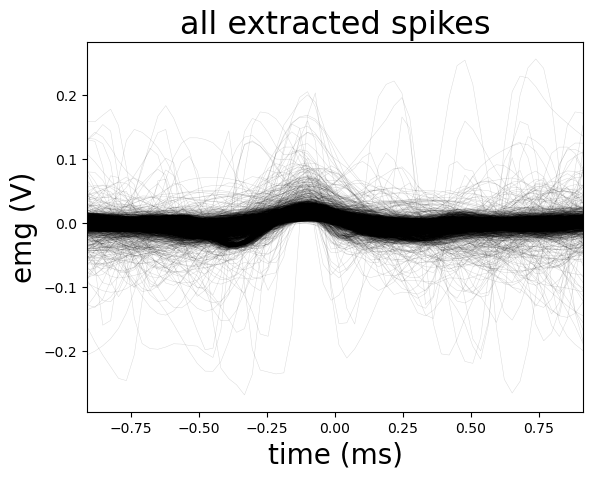

In [96]:
# plot
fig, ax  = plt.subplots()

for spike in spike_arr:
    ax.plot(1000*spike_t, spike, 'k', lw=0.35, alpha=0.15)
    
# ax.plot(spike_t, np.mean(spike_arr, axis=0), 'k-')

# axis props
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xlabel('time (ms)', fontsize=20) ;
ax.set_ylabel('emg (V)', fontsize=20) ;
ax.set_title('all extracted spikes', fontsize=23)
# ax.set_ylim([-0.1, 0.2])

In [97]:
# what about 'spikes' that have mean value much below zero at initial time window?
init_mean = np.mean(spike_arr[:,:512], axis=1)
rm_idx = init_mean < -1*thresh

spike_arr = spike_arr[~rm_idx,:]
peaks = peaks[~rm_idx]
right_diff_new = right_diff_new[~rm_idx]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4043 but corresponding boolean dimension is 4037

In [98]:
np.sum(rm_idx)  # 197

89

In [99]:
spike_window/4

8.0

## Try to cluster spikes

In [100]:
# try PCA first
pca = PCA(n_components=20)  # PCA(n_components=20)
pca.fit(spike_arr)
pca_result = pca.transform(spike_arr)



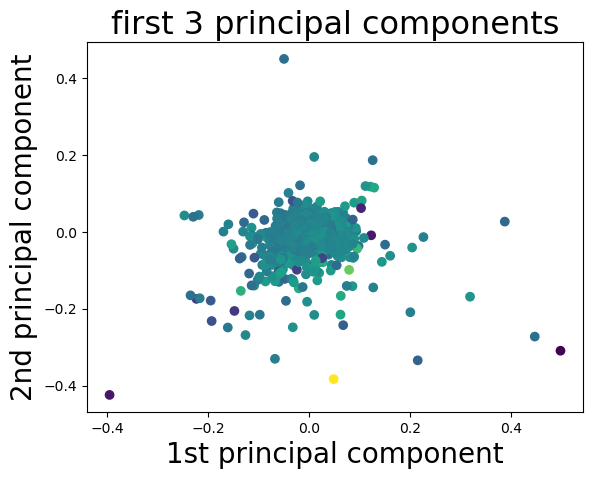

In [101]:
# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots()
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 3 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.31618454773698523
For n_clusters = 3 The average silhouette_score is : 0.3170627731407003
For n_clusters = 4 The average silhouette_score is : 0.31592076942467173
For n_clusters = 5 The average silhouette_score is : 0.3120198140456636
For n_clusters = 6 The average silhouette_score is : 0.2804352160472577
For n_clusters = 7 The average silhouette_score is : 0.2794311609816552
For n_clusters = 8 The average silhouette_score is : 0.15027181742291665


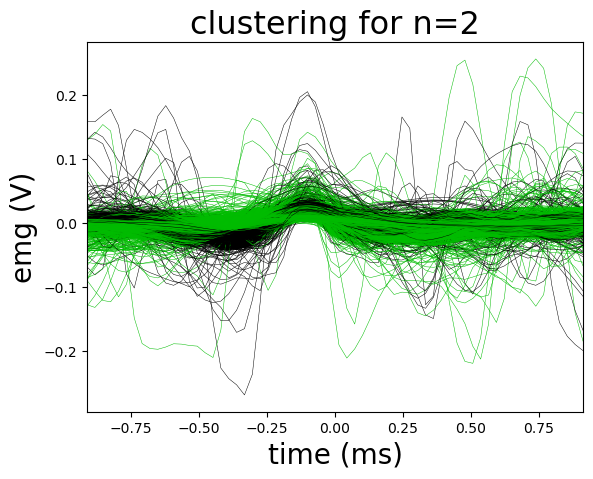

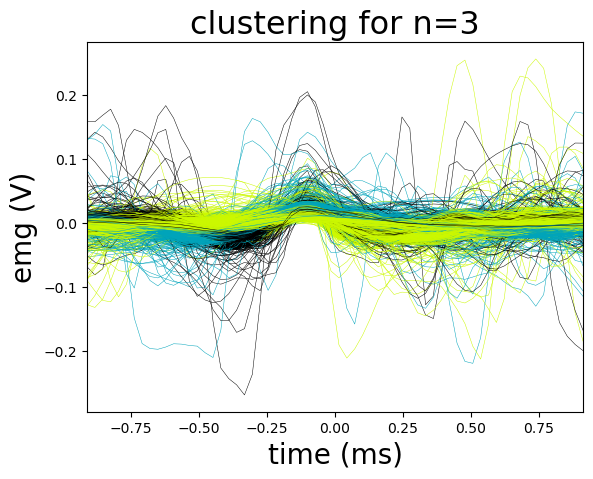

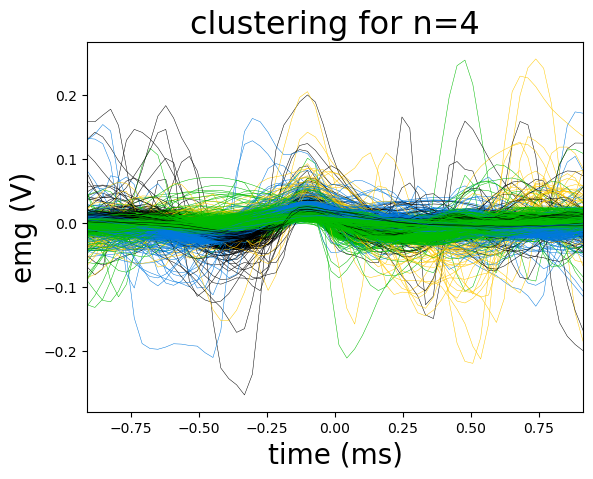

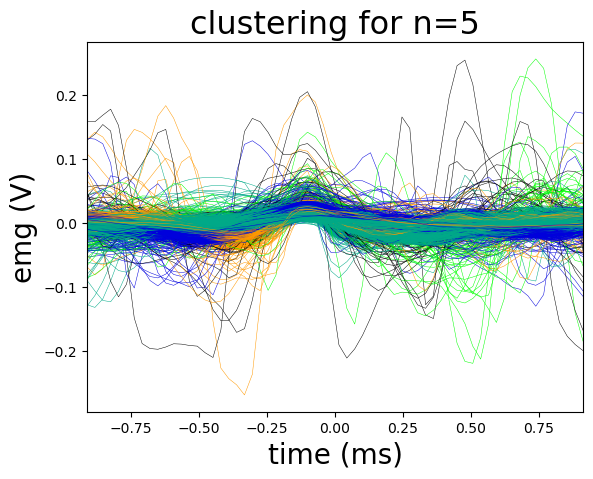

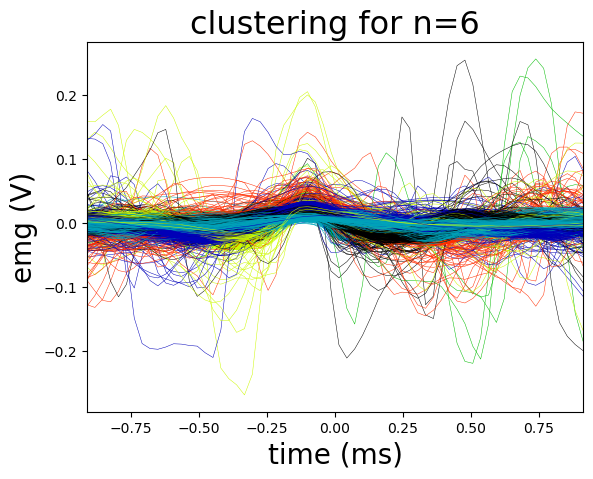

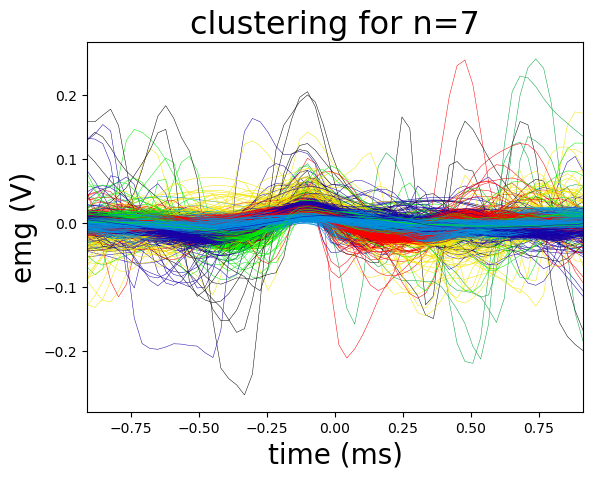

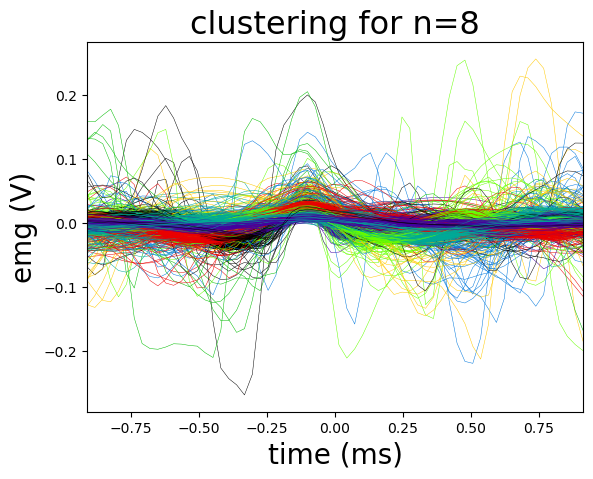

In [102]:
# do clustering on PCA components
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avgs = list()

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 47 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=47, n_init='auto')
    cluster_labels = clusterer.fit_predict(pca_result)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pca_result, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    silhouette_avgs.append(silhouette_avg)
    
    # plot clustering in waveform space
    fig, ax = plt.subplots()
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    for spike, col in zip(spike_arr, colors):
        ax.plot(1000*spike_t, spike, color=col, lw=0.35)
        
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.set_xlabel('time (ms)', fontsize=20) ;
    ax.set_ylabel('emg (V)', fontsize=20) ;
    ax.set_title('clustering for n={}'.format(n_clusters), fontsize=23)

Text(0.5, 1.0, 'Silhouette score vs cluster count')

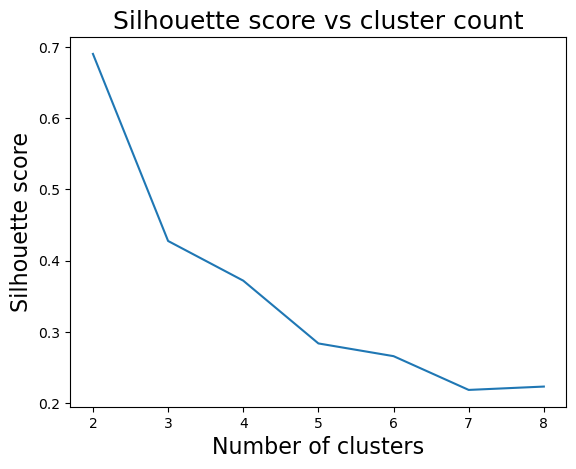

In [697]:
# visualize silhouette scores
fig, ax = plt.subplots()

ax.plot(range_n_clusters, silhouette_avgs)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette score vs cluster count')

In [698]:
# pick a cluster number (probably the value before a big drop-off?) and continue
n_clusters = 1 # range_n_clusters[np.argmax(silhouette_avgs)]
clusterer = KMeans(n_clusters=n_clusters, random_state=47, n_init='auto')
cluster_labels = clusterer.fit_predict(pca_result)

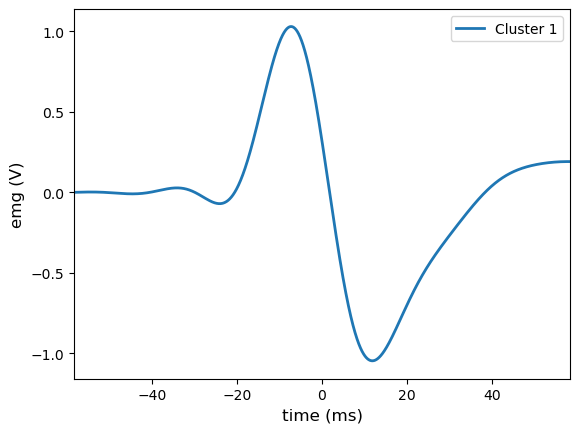

In [699]:
# visualize the mean for each cluster
clust_vals = np.unique(cluster_labels)
fig, ax = plt.subplots()

for val in clust_vals:
    # get cluster mean and standard error
    cluster_mean = np.mean(spike_arr[cluster_labels == val, :], axis=0)
    cluster_std = np.std(spike_arr[cluster_labels == val, :], axis=0)
    cluster_se = cluster_std/np.sqrt(np.sum(cluster_labels == val))
    
    # plot
    ax.fill_between(1000*spike_t, cluster_mean-cluster_se, cluster_mean+cluster_se, alpha=0.15)
    ax.plot(1000*spike_t, cluster_mean, label='Cluster {}'.format(val+1), lw=2.0)

    
# axis props
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xlabel('time (ms)', fontsize=12) ;
ax.set_ylabel('emg (V)', fontsize=12) ;
plt.legend()

In [700]:
# # check right_diff values of clustered peaks
# fig, ax = plt.subplots()

# for val in clust_vals:
#     ax.hist(right_diff_new[cluster_labels == val], bins=20, density=True)
    
# ax.set_xlabel('right diff')
# ax.set_ylabel('pdf')

## What are the mic values during spikes?

In [701]:
# need to estimate mic signal phase
analytic_mic = signal.hilbert(abf_df['Microphon_filt'])
# amplitude_envelope = np.abs(analytic_signal)
mic_phase = np.angle(analytic_mic)


In [702]:
# also try to get frequency values from this
mic_freq = (np.diff(np.unwrap(mic_phase)) / (2.0*np.pi) * Fs)

In [703]:
if 'Microphon' in abf_dict:
    print('yes')

yes


Text(0.5, 0, 'time (s)')

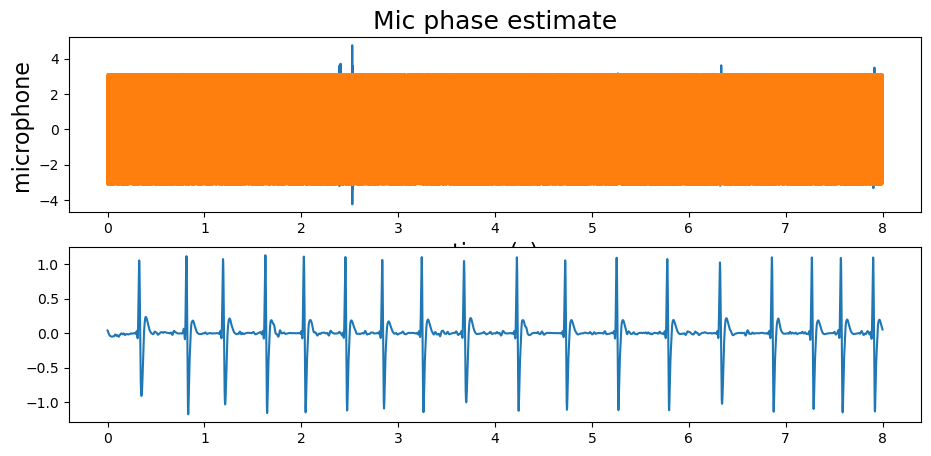

In [704]:
fig, (ax, ax2) = plt.subplots(2,1,figsize=(11,5))

xmin = 0 # 0.01 
xmax = 8  # 0.05
mask = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)

ax.plot(abf_df['Time'][mask], abf_df['Microphon_filt'][mask])
ax.plot(abf_df['Time'][mask], mic_phase[mask])
ax2.plot(abf_df['Time'][mask], abf_df['EMG_filt'][mask])

# ax.set_xlim([0,0.05])
ax.set_title('Mic phase estimate')
ax.set_ylabel('microphone')
ax.set_xlabel('time (s)')


In [705]:
# # frequency from Hilbert transform
# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(11,5))

# xmin = 97.6
# xmax = 97.7
# mask = (abf_df['Time'][:-1] >= xmin) & (abf_df['Time'][:-1] <= xmax)
# mask_full = (abf_df['Time'] >= xmin) & (abf_df['Time'] <= xmax)

# ax1.plot(abf_df['Time'][mask_full], abf_df['Microphon_filt'][mask_full])
# ax2.plot(abf_df['Time'][:-1][mask], mic_freq[mask])
# # ax.set_ylim([0, 1000])


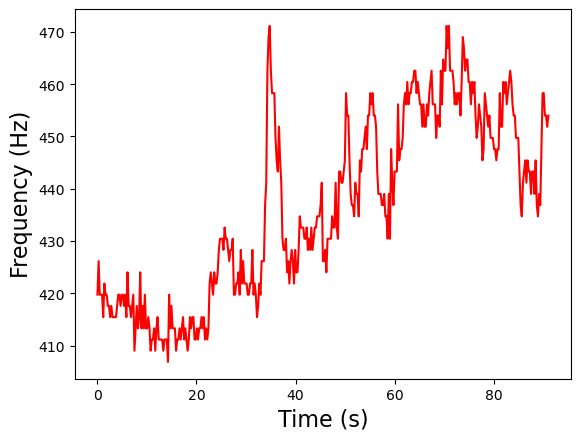

In [706]:
# frequency from STFT
f, t, Zxx = signal.stft(abf_df['Microphon_filt'], Fs, nperseg=8*2048)

# get max vals at each time point
freq_max_idx = np.argmax(np.abs(Zxx), axis=0)
freq_max = f[freq_max_idx]

# plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.plot(t, freq_max, 'r-')

# plt.title('STFT Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
# plt.ylim([550, 800])
plt.show()

# then need to upsample to full freq
mic_freq = np.interp(abf_df['Time'], t, freq_max)


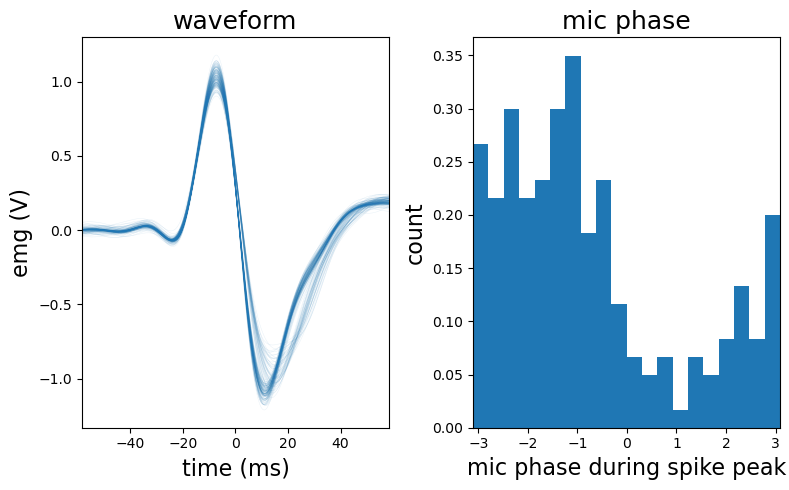

In [707]:
# make histogram of mic PHASE during spike
fig, ax_list = plt.subplots(n_clusters, 2, figsize=(8, 5))

if n_clusters == 1:
    ax_list = ax_list[np.newaxis, :]
clust_vals = np.unique(cluster_labels)

# set color scheme/palette for visualization
cmap = plt.colormaps['tab10']
colors = cmap(np.linspace(0, 1, cmap.N))

for val, color in zip(clust_vals, colors):
    # get mic phase during current spike cluster peaks
    spike_mic_phase = mic_phase[peaks][cluster_labels==val]
    
    # also get waveforms for current cluster spikes
    spike_arr_clust = spike_arr[cluster_labels==val, :]
    
    # plot time series
    for spike in spike_arr_clust:
        ax_list[val, 0].plot(1000*spike_t, spike, color=color, lw=0.35, alpha=0.1)
    
    ax_list[val, 0].set_ylabel('emg (V)')
    ax_list[val, 0].set_title('waveform')
    ax_list[val, 0].autoscale(enable=True, axis='x', tight=True)

    # plot histogram
    ax_list[val, 1].hist(spike_mic_phase, bins=20, density=True, color=color)
    
    # ax_list[val, 1].set_title('cluster {}'.format(val + 1))
    ax_list[val, 1].set_title('mic phase')
    ax_list[val, 1].set_ylabel('count')
    ax_list[val, 1].autoscale(enable=True, axis='x', tight=True)


ax_list[val, 0].set_xlabel('time (ms)')
ax_list[val, 1].set_xlabel('mic phase during spike peak')

plt.tight_layout()

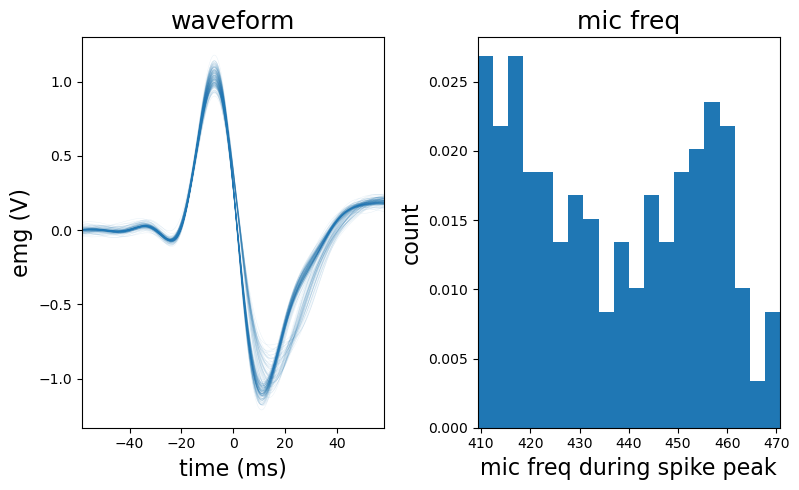

In [708]:
# make histogram of mic FREQUENCY (WBF) during spike
fig, ax_list = plt.subplots(n_clusters, 2, figsize=(8, 5))

if n_clusters == 1:
    ax_list = ax_list[np.newaxis, :]
    
clust_vals = np.unique(cluster_labels)

# set color scheme/palette for visualization
cmap = plt.colormaps['tab10']
colors = cmap(np.linspace(0, 1, cmap.N))

for val, color in zip(clust_vals, colors):
    # get mic phase during current spike cluster peaks
    spike_mic_freq = mic_freq[peaks][cluster_labels==val]
    
    # also get waveforms for current cluster spikes
    spike_arr_clust = spike_arr[cluster_labels==val, :]
    
    # plot time series
    for spike in spike_arr_clust:
        ax_list[val, 0].plot(1000*spike_t, spike, color=color, lw=0.35, alpha=0.1)
    
    ax_list[val, 0].set_ylabel('emg (V)')
    ax_list[val, 0].set_title('waveform')
    ax_list[val, 0].autoscale(enable=True, axis='x', tight=True)

    # plot histogram
    ax_list[val, 1].hist(spike_mic_freq, bins=20, density=True, color=color)
    
    # ax_list[val, 1].set_title('cluster {}'.format(val + 1))
    ax_list[val, 1].set_title('mic freq')
    ax_list[val, 1].set_ylabel('count')
    ax_list[val, 1].autoscale(enable=True, axis='x', tight=True)


ax_list[val, 0].set_xlabel('time (ms)')
ax_list[val, 1].set_xlabel('mic freq during spike peak')

plt.tight_layout()

TypeError: 'Axes' object is not subscriptable

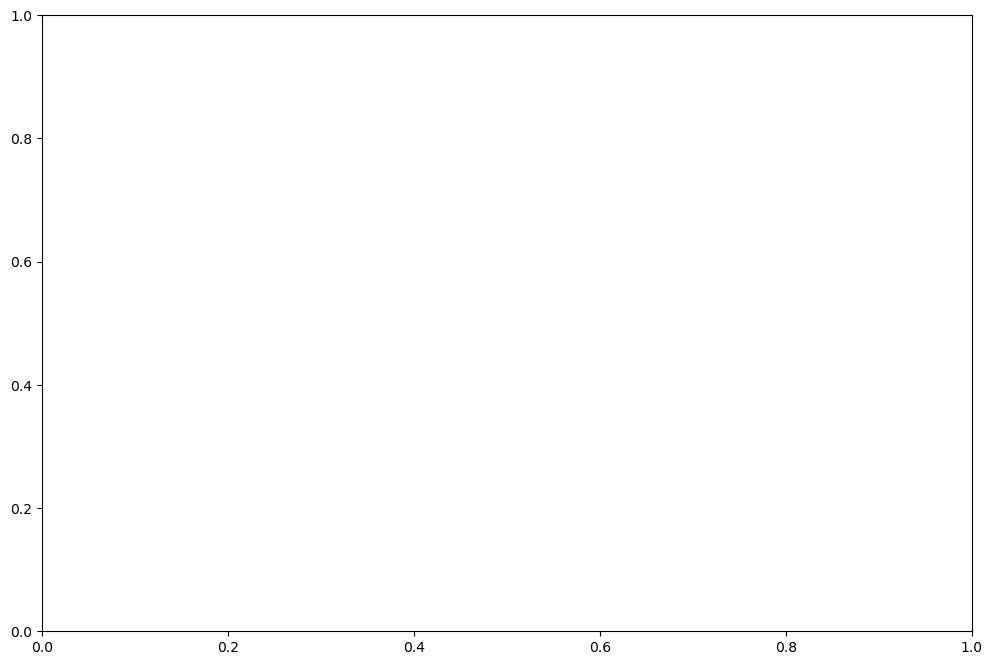

In [709]:
# look at relative timing of spikes in a raster plot
fig, ax_list = plt.subplots(n_clusters, 1, figsize=(12, 8), sharex=True)

if n_clusters == 1:
    ax_list = ax_list[np.newaxis, :]
    
clust_vals = np.unique(cluster_labels)
t = abf_df['Time']

# set color scheme/palette for visualization
cmap = plt.colormaps['tab10']
colors = cmap(np.linspace(0, 1, cmap.N))

for val, color in zip(clust_vals, colors):
    # spike times for current type
    spike_times = t[peaks][cluster_labels==val]
    
    # plot
    for st in spike_times:
        ax_list[val].axvline(st, color=color, lw=0.5)
    
    # ax props
    ax_list[val].autoscale(enable=True, axis='x', tight=True)
    ax_list[val].set_ylabel('Cluster {}'.format(val+1))
    

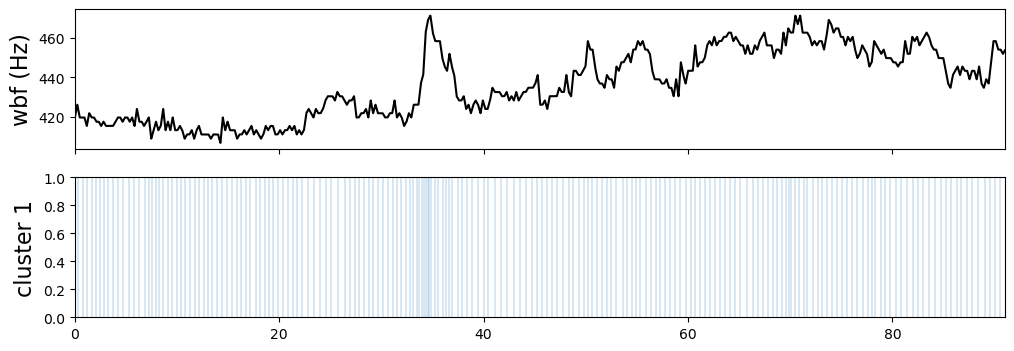

In [717]:
# quick check of wbf and spike rate
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 4), sharex=True)

t = abf_df['Time']

# plot wbf
ax1.plot(abf_df['Time'], mic_freq, 'k-')
ax1.set_ylabel('wbf (Hz)')
ax1.autoscale(enable=True, axis='x', tight=True)

# plot spike raster
val = 0
spike_times = t[peaks][cluster_labels==val]

# plot
for st in spike_times:
    ax2.axvline(st, color=colors[val], lw=0.25)
ax2.set_ylabel('cluster {}'.format(val + 1))
ax2.autoscale(enable=True, axis='x', tight=True) 

## Kernel method for extracting instantaneous firing rate

In [718]:
# create binary vector of spike times
# NB: probably want to do this by spike type
t = abf_df['Time']
spike_idx = np.zeros(t.shape, dtype=bool)
spike_idx[peaks[cluster_labels==0]] = True


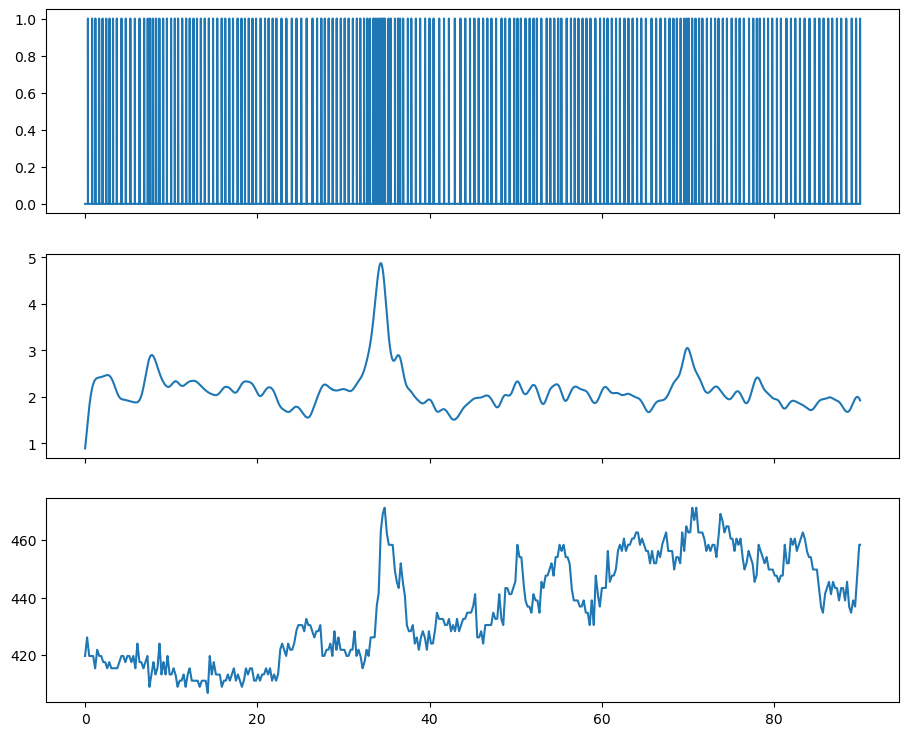

In [748]:
# generate gaussian window for convolution
# for POWER muscles
gauss_win = signal.windows.gaussian(8*16*1024, 8*8*256.0)

# for STEERING muscles
# gauss_win = signal.windows.gaussian(16*1024, 8*256.0)

# perform convolution
spike_freq = Fs*signal.convolve(spike_idx, gauss_win, mode='same')/np.sum(gauss_win)  # Fs*signal.filtfilt(gauss_win, 1, spike_idx)

# visualize 
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(11,9), sharex=True)

xmin = 0
xmax = 90
mask = (t >= xmin) & (t <= xmax)

ax1.plot(t[mask], spike_idx[mask])
ax2.plot(t[mask], spike_freq[mask])
ax3.plot(t[mask], mic_freq[mask])
# ax2.set_xlim([xmin, xmax])
# ax2.set_ylim([0, 4])

In [746]:
#np.mean(np.diff(spike_idx))
mean_isi = np.mean(np.diff(np.where(spike_idx)[0]))
win_pts = 2**np.round(np.log2(mean_isi))
win_pts

16384.0

In [741]:
8*8*256.0

16384.0

In [744]:
8*16*1024 /16384

8.0